# Late Fusion: Audio Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/audio/'
output_path = '../out/audio/'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_train.csv'))
gemaps_df = pd.read_csv(os.path.join(input_path, 'gemaps', 'audio_data_gemaps_train.csv'))

In [5]:
egemaps_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,actor_id,file_id,target,group
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.330578,0.037114,0.117179,0.047826,0.088380,0.731259,1,0,1,4
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.264558,0.055237,0.089090,0.057971,0.000000,0.725443,1,1,1,4
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.344937,0.038350,0.090084,0.050725,0.049834,0.742759,1,2,1,4
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.337101,0.039662,0.074729,0.045894,0.040150,0.789177,1,3,1,4
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.161629,0.090247,0.320940,0.045894,0.058668,0.764986,1,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.192274,0.065019,0.064878,0.086957,0.127309,0.693686,10,1255,17,5
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.396111,0.023316,0.090696,0.077122,0.096082,0.760948,10,1256,17,5
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.376332,0.022740,0.107705,0.091938,0.147996,0.786001,10,1257,17,5
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.155720,0.063989,0.077539,0.134058,0.268334,0.721901,10,1258,17,5


In [6]:
from sklearn.utils import shuffle

egemaps_shuffled_df = shuffle(egemaps_df, random_state=seed).reset_index(drop=True)
gemaps_shuffled_df = shuffle(gemaps_df, random_state=seed).reset_index(drop=True)

In [7]:
egemaps_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,actor_id,file_id,target,group
0,0.240379,0.614553,0.089265,0.219347,0.284260,0.280270,0.303624,0.200022,0.262954,0.033284,...,0.235860,0.045146,0.114542,0.072464,0.140819,0.082002,3,315,9,3
1,0.428243,0.121044,0.397641,0.397569,0.437531,0.122617,0.148100,0.015786,0.218510,0.011256,...,0.311049,0.026147,0.037864,0.115942,0.204594,0.731306,9,1117,15,4
2,0.499724,0.243378,0.437738,0.420981,0.586214,0.260613,0.142826,0.018867,0.205943,0.003317,...,0.134254,0.114960,0.138889,0.043478,0.000000,0.478746,8,987,14,5
3,0.294653,0.605192,0.026334,0.314250,0.475608,0.586494,0.137131,0.002755,0.226926,0.000000,...,0.378653,0.019025,0.143761,0.100644,0.155143,0.633834,9,1067,9,4
4,0.154184,0.620439,0.076768,0.134368,0.172950,0.157283,0.179695,0.035599,0.277163,0.124323,...,0.240382,0.047964,0.202761,0.067391,0.060728,0.159401,3,323,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.800665,0.175227,0.745947,0.790104,0.808547,0.188162,0.173931,0.011665,0.205735,0.023853,...,0.100549,0.115733,0.295122,0.115942,0.090744,0.838798,2,141,3,1
1255,0.339490,0.457571,0.146215,0.395539,0.453824,0.425043,0.180069,0.018150,0.230690,0.016112,...,0.275777,0.033870,0.113277,0.076812,0.033838,0.792443,9,1049,6,4
1256,0.628904,0.354822,0.665858,0.633961,0.696183,0.139788,0.381234,0.154791,0.274983,0.100322,...,0.386604,0.024603,0.093439,0.082609,0.087039,0.584423,6,753,17,2
1257,0.663620,0.149773,0.618283,0.661143,0.654561,0.141982,0.142250,0.015549,0.208364,0.004063,...,0.105917,0.096812,0.233341,0.230072,0.270494,0.694067,5,543,6,3


## Other functions

In [16]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([18,18])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_eng_id_to_emotion_num.keys()), list(emotion_eng_id_to_emotion_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Elastic Net SGD Classifier

### eGeMAPS

In [8]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 48.4min finished


SGDClassifier(alpha=0.00075, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=2500,
              n_iter_no_change=100, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=27, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [9]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
262,3.114908,0.043891,0.239309,0.005154,0.00075,balanced,0.3,log,2500,100,...,27,"{'alpha': 0.00075, 'class_weight': 'balanced',...",0.836770,0.793586,0.839243,0.799448,0.829067,0.819623,0.019252,1
268,0.896764,0.022112,0.245781,0.016881,0.00075,balanced,0.4,log,2500,20,...,27,"{'alpha': 0.00075, 'class_weight': 'balanced',...",0.838326,0.795038,0.837851,0.797645,0.829209,0.819614,0.019295,2
263,4.142454,0.091232,0.242406,0.012333,0.00075,balanced,0.3,log,2500,150,...,27,"{'alpha': 0.00075, 'class_weight': 'balanced',...",0.836809,0.794351,0.838399,0.798708,0.829715,0.819596,0.019109,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9136105283660042
AUC_std (train): 0.0018472148952345267
AUC_avg (validation): 0.8196226025759105
AUC_std (validation): 0.019251567913203416


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


UAR_avg (train): 0.5089223613284647
UAR_std (train): 0.01069978338924893
UAR_avg (validation): 0.2618010167029775
UAR_std (validation): 0.035044739117958336


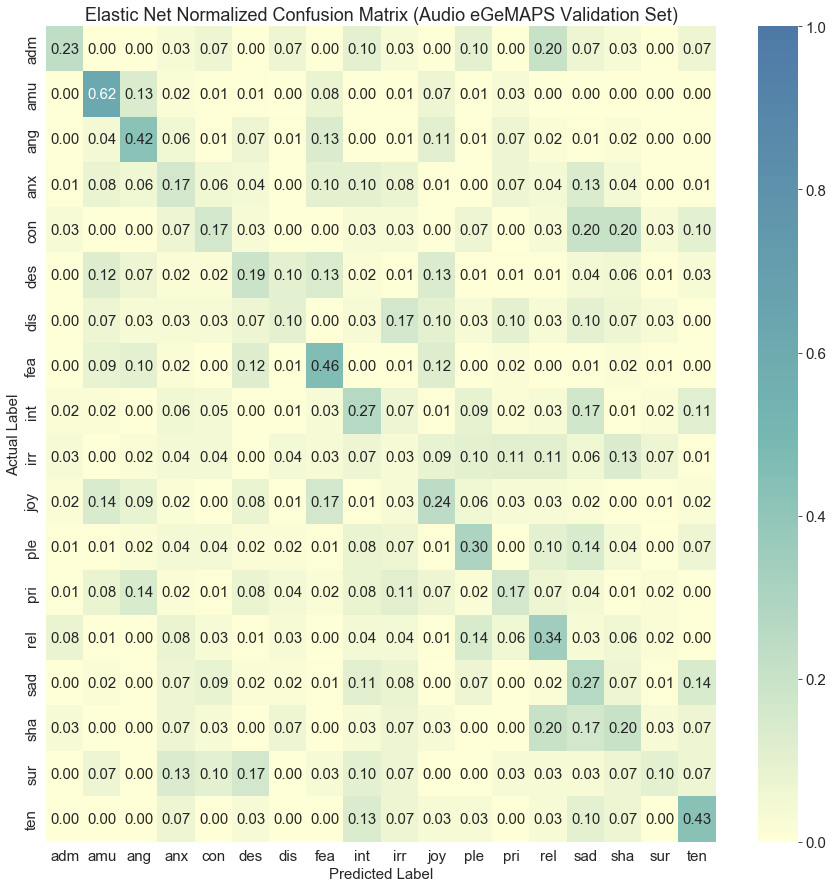

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Audio eGeMAPS Validation Set)',
                      file_name = 'conf_mat_elastic_net_egemaps_audio.svg',
                      report    = True 
                     )

### GeMAPS

In [11]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_gemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_gemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_gemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 35.0min finished


SGDClassifier(alpha=0.0005, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.35, learning_rate='optimal', loss='log', max_iter=2500,
              n_iter_no_change=100, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=27, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [12]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
186,2.242148,0.074045,0.246765,0.003192,0.0005,balanced,0.35,log,2500,100,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.826473,0.779152,0.825895,0.783432,0.827887,0.808568,0.022321,1
213,1.275865,0.088258,0.260214,0.017487,0.0005,balanced,0.7,log,2500,50,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.829209,0.780358,0.824479,0.780320,0.827666,0.808407,0.022968,2
194,2.162577,0.087009,0.242535,0.016882,0.0005,balanced,0.45,log,2500,100,...,27,"{'alpha': 0.0005, 'class_weight': 'balanced', ...",0.825786,0.779243,0.825691,0.782874,0.827692,0.808257,0.022249,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9033637962604157
AUC_std (train): 0.002849663188123549
AUC_avg (validation): 0.8085677982187678
AUC_std (validation): 0.022320966352015758


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


UAR_avg (train): 0.4840788558511563
UAR_std (train): 0.016339089016760636
UAR_avg (validation): 0.24262890341321713
UAR_std (validation): 0.026980088157582082


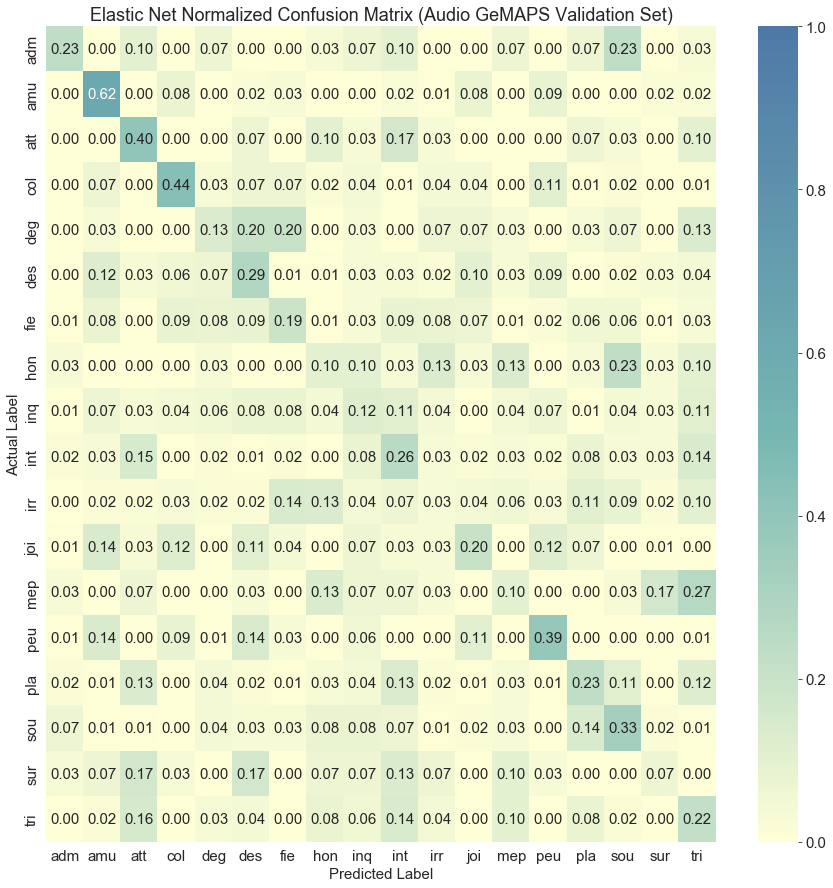

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_gemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Audio GeMAPS Validation Set)',
                      file_name = 'conf_mat_elastic_net_gemaps_audio.svg'
                     )

## kNN Classifier

### eGeMAPS

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 15.5min


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=181, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 8145 out of 8145 | elapsed: 17.5min finished


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
941,0.005049,0.000925,0.495602,0.097046,brute,30,manhattan,-1,181,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",0.79511,0.746615,0.801293,0.772837,0.766217,0.776414,0.019866,1
36,0.012163,0.006484,0.557243,0.090763,ball_tree,10,manhattan,-1,181,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.79511,0.746615,0.801293,0.772837,0.766217,0.776414,0.019866,1
579,0.005017,0.000751,0.389575,0.017501,brute,10,manhattan,-1,181,uniform,"{'algorithm': 'brute', 'leaf_size': 10, 'metri...",0.79511,0.746615,0.801293,0.772837,0.766217,0.776414,0.019866,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.824388051012018
AUC_std (train): 0.005570426316082694
AUC_avg (validation): 0.7764142644619584
AUC_std (validation): 0.01986566307303427


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


UAR_avg (train): 0.2097722135280821
UAR_std (train): 0.010023851565907557
UAR_avg (validation): 0.17737835875090777
UAR_std (validation): 0.025077084503872478


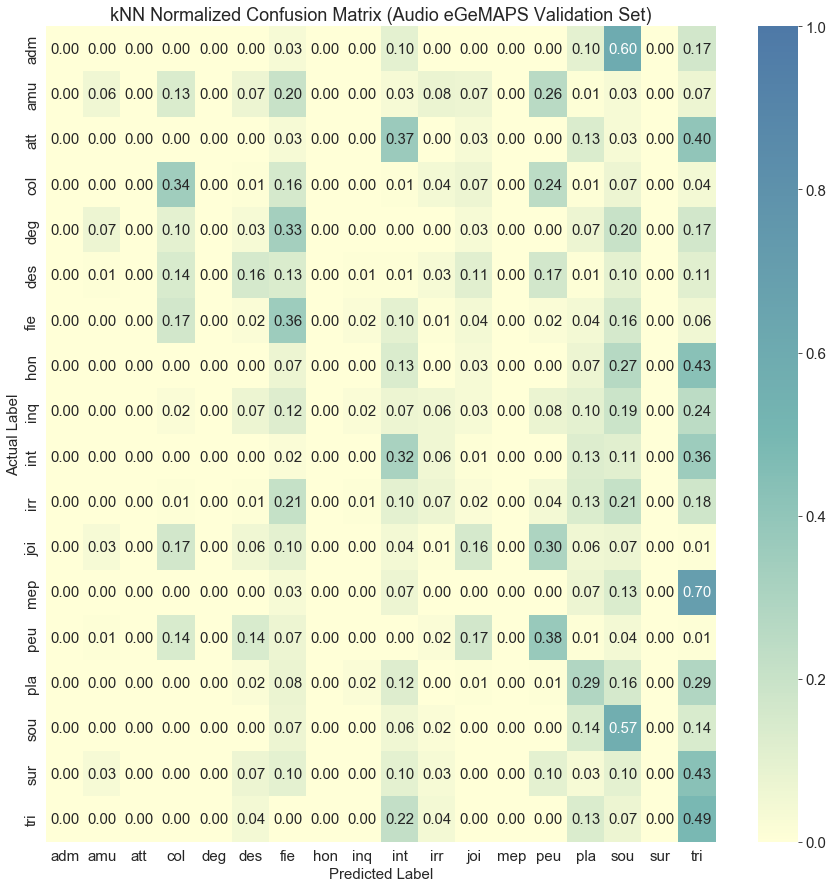

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Audio eGeMAPS Validation Set)',
                      file_name = 'conf_mat_knn_egemaps_audio.svg'
                     )

### GeMAPS

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_gemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_gemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_gemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 15.0min


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=226, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 8145 out of 8145 | elapsed: 17.2min finished


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
407,0.005901,0.000977,0.369221,0.007329,ball_tree,30,manhattan,-1,226,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.79594,0.746097,0.795577,0.76682,0.776248,0.776136,0.018758,1
769,0.007420,0.002647,0.477514,0.031862,brute,20,manhattan,-1,226,uniform,"{'algorithm': 'brute', 'leaf_size': 20, 'metri...",0.79594,0.746097,0.795577,0.76682,0.776248,0.776136,0.018758,1
588,0.006574,0.004622,0.448578,0.059680,brute,10,manhattan,-1,226,uniform,"{'algorithm': 'brute', 'leaf_size': 10, 'metri...",0.79594,0.746097,0.795577,0.76682,0.776248,0.776136,0.018758,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.8164102798891394
AUC_std (train): 0.005605519969809446
AUC_avg (validation): 0.7761360236358169
AUC_std (validation): 0.01875791043859554


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


UAR_avg (train): 0.20626630151278041
UAR_std (train): 0.011386517979825104
UAR_avg (validation): 0.18351488743645605
UAR_std (validation): 0.017483726115990163


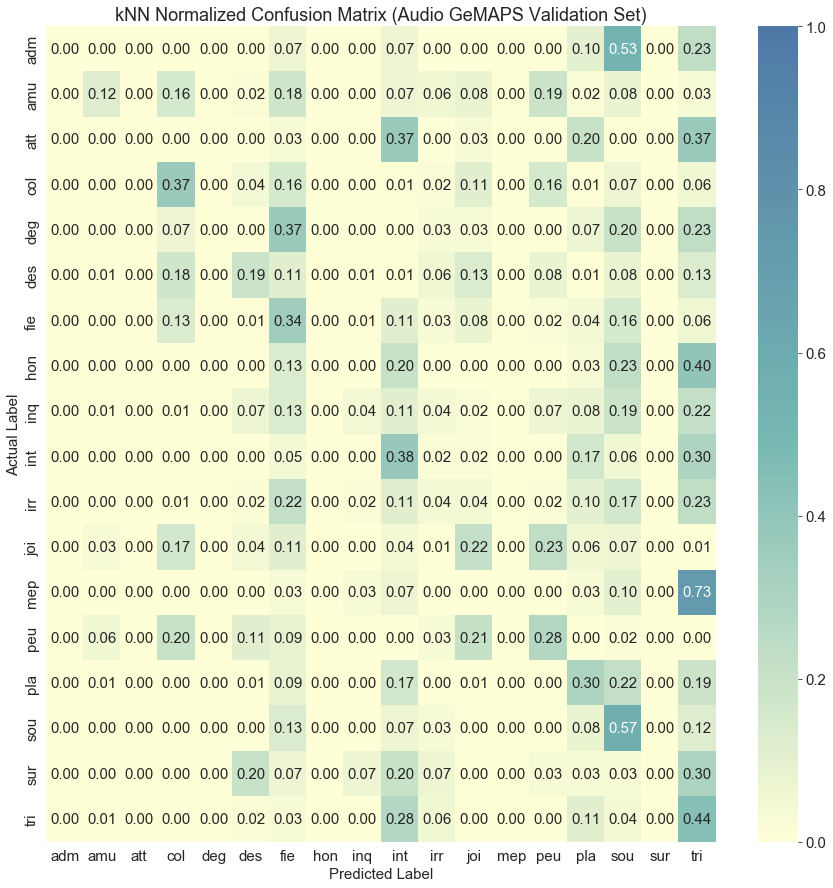

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_gemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Audio GeMAPS Validation Set)',
                      file_name = 'conf_mat_knn_gemaps_audio.svg'
                     )

## Decision Tree

### eGeMAPS

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_features=52,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.1,
                       min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=27, splitter='best')


In [28]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4273,0.078240,0.005539,0.273237,0.004454,best,27,0.2,0.1,52,40,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.720595,0.659904,0.712814,0.69565,0.720835,0.701959,0.022934,1
1284,0.076409,0.002820,0.274662,0.006854,best,27,0.2,0.1,52,10,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.720595,0.659904,0.712814,0.69565,0.720835,0.701959,0.022934,1
4265,0.074281,0.004352,0.277661,0.014198,best,27,0.2,0.1,52,50,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.720595,0.659904,0.712814,0.69565,0.720835,0.701959,0.022934,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.7742559380904488
AUC_std (train): 0.006787393891882181
AUC_avg (validation): 0.7019594963123043
AUC_std (validation): 0.022934022567140812


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


UAR_avg (train): 0.21466049382716051
UAR_std (train): 0.011726364346612908
UAR_avg (validation): 0.14259259259259258
UAR_std (validation): 0.028913675132420668


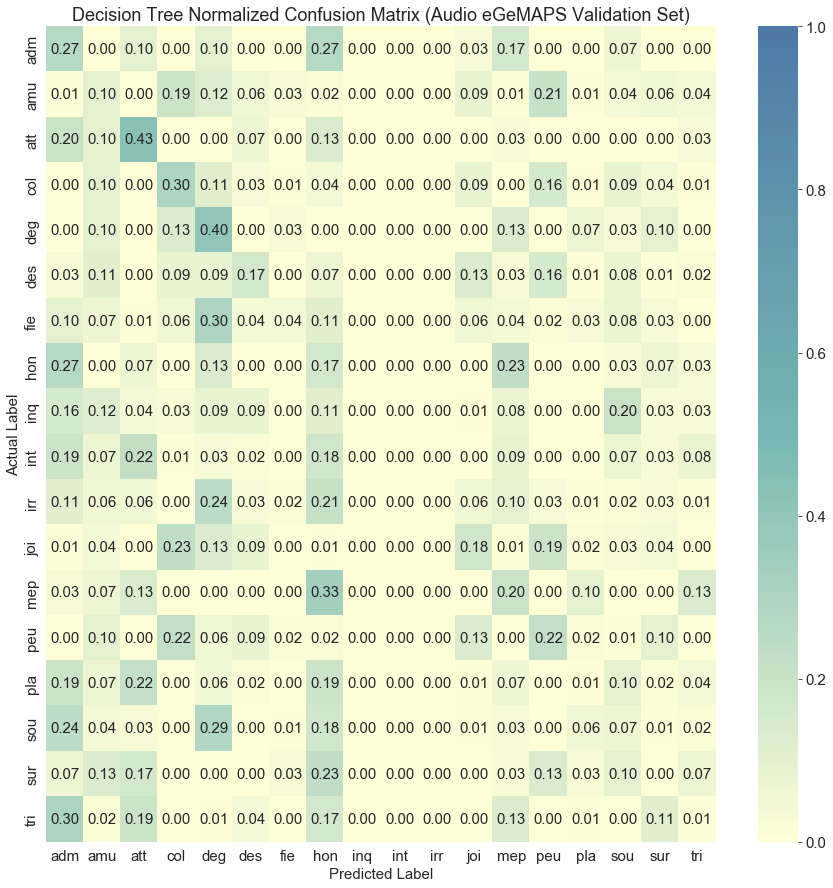

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Audio eGeMAPS Validation Set)',
                      file_name = 'conf_mat_tree_egemaps_audio.svg'
                     )

### GeMAPS

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_gemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_gemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_gemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_features=22,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.1,
                       min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=27, splitter='best')


In [31]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4216,0.033768,0.004090,0.287777,0.008432,best,27,0.2,0.1,22,50,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.746479,0.688512,0.720286,0.648187,0.711277,0.702948,0.033082,1
1629,0.021565,0.000837,0.277369,0.005807,best,27,0.1,0.1,44,15,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.709215,0.665986,0.718879,0.699580,0.709157,0.700563,0.018334,2
1579,0.021367,0.001042,0.284743,0.009844,best,27,0.2,0.1,44,35,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.709215,0.665986,0.718879,0.699580,0.709157,0.700563,0.018334,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


AUC_avg (train): 0.769493496705737
AUC_std (train): 0.007279296940596929
AUC_avg (validation): 0.7029481835873341
AUC_std (validation): 0.03308207326130565
UAR_avg (train): 0.21203703703703702
UAR_std (train): 0.004716267527758064
UAR_avg (validation): 0.15679012345679014
UAR_std (validation): 0.03001295254603264


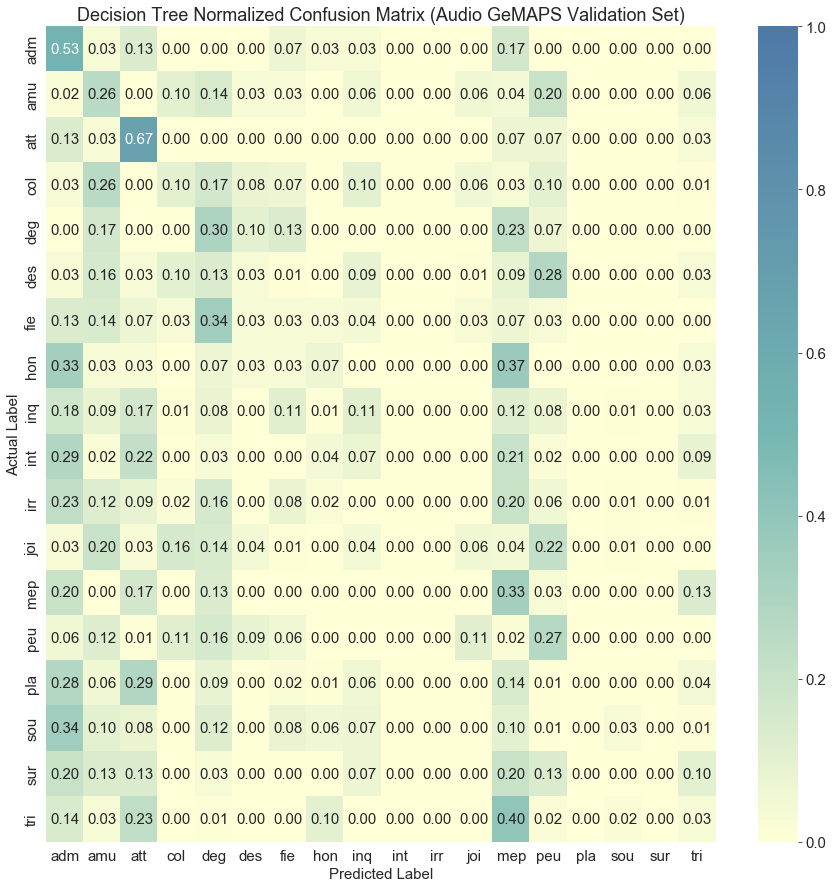

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_gemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Audio GeMAPS Validation Set)',
                      file_name = 'conf_mat_tree_gemaps_audio.svg'
                     )

## Random Forest

### eGeMAPS

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_egemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_egemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 90.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 124.0min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 143.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 163.4min
[Parallel(n_jobs=-1)]: Done 11242 tasks   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=470,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4167,4.272253,0.121785,0.707933,0.080972,27,-1,470,5,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.821960,0.775003,0.808774,0.770995,0.812610,0.797868,0.020793,1
4417,4.363859,0.145605,0.649879,0.123425,27,-1,490,5,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.820819,0.775288,0.808665,0.771475,0.812753,0.797800,0.020353,2
1893,3.645988,0.087675,0.725149,0.032784,27,-1,405,5,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.820689,0.773200,0.810210,0.771696,0.812857,0.797730,0.020934,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9982981774864909
AUC_std (train): 0.00031667641125191203
AUC_avg (validation): 0.7978684542935038
AUC_std (validation): 0.020792630738836783


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


UAR_avg (train): 0.9791579725265172
UAR_std (train): 0.0027630187361478644
UAR_avg (validation): 0.24012345679012345
UAR_std (validation): 0.0406377298534143


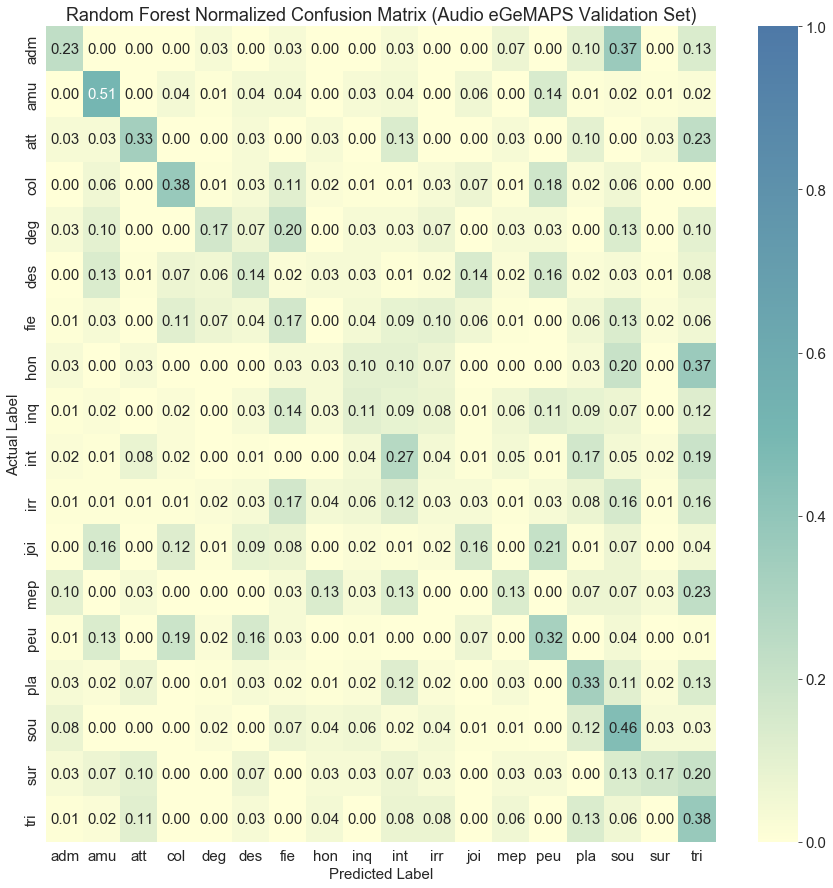

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = egemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = egemaps_shuffled_df.target
groups = egemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Audio eGeMAPS Validation Set)',
                      file_name = 'conf_mat_rf_egemaps_audio.svg'
                     )

### GeMAPS

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_gemaps_audio.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_gemaps_audio.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_gemaps_audio.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 97.4min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 113.7min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 130.9min
[Parallel(n_jobs=-1)]: Done 11242 tasks     

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


In [34]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4907,2.680842,0.153937,0.526579,0.109593,27,-1,346,10,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.812857,0.778737,0.811601,0.773745,0.818511,0.799090,0.018867,1
4602,2.506783,0.206179,0.594856,0.138320,27,-1,326,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.811832,0.778141,0.812646,0.773874,0.818277,0.798954,0.018915,2
2976,2.276611,0.159245,0.663766,0.209809,27,-1,321,10,4,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.812338,0.777894,0.812363,0.773900,0.818212,0.798942,0.018979,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9966864472706789
AUC_std (train): 0.00037209317225136946
AUC_avg (validation): 0.7990901622390661
AUC_std (validation): 0.018867068255502703


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


UAR_avg (train): 0.9519866110241697
UAR_std (train): 0.004835775984052658
UAR_avg (validation): 0.25925925925925924
UAR_std (validation): 0.04057204129667896


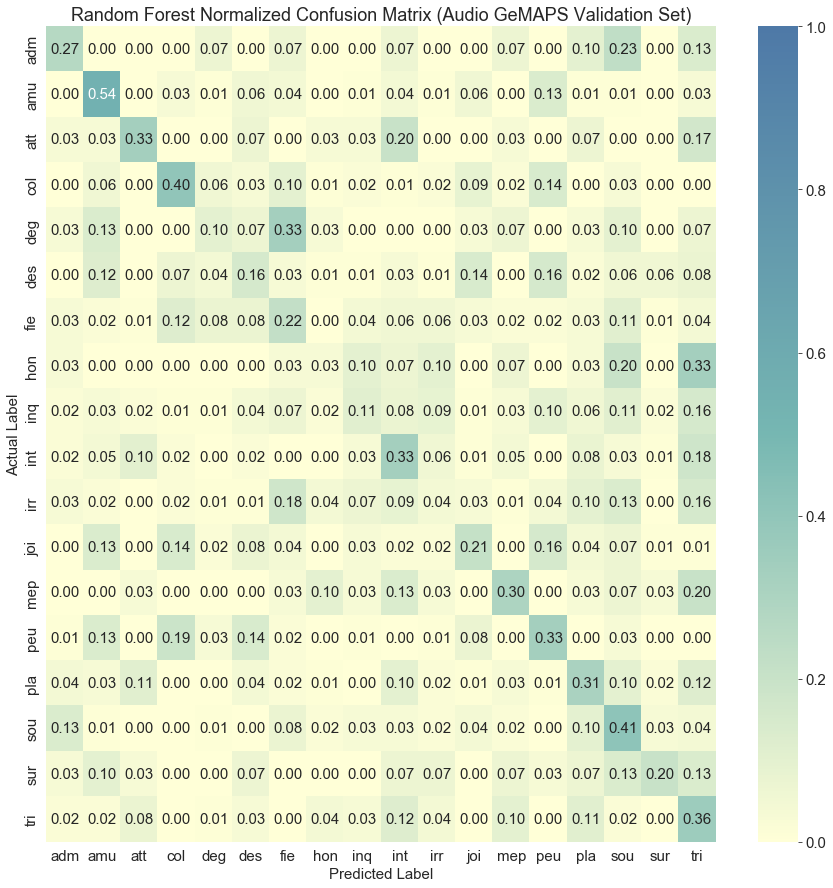

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = gemaps_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = gemaps_shuffled_df.target
groups = gemaps_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_gemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,                        
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Audio GeMAPS Validation Set)',
                      file_name = 'conf_mat_rf_gemaps_audio.svg'
                     )